In [1]:
import astropy.units as u
from astropy.utils import data
from spectral_cube import SpectralCube, LazyMask
import matplotlib.pyplot as plt 
from astropy.io import fits
import numpy as np
from astropy.wcs import WCS
%matplotlib inline
import warnings; warnings.filterwarnings('ignore')
from astropy import constants as const
import matplotlib.pyplot as plt
from photutils.aperture import EllipticalAperture
import photutils
from photutils import aperture_photometry
from photutils.isophote import Ellipse
from photutils.isophote import EllipseGeometry

plt.rc('axes', lw = 2)
plt.rc('font', family = 'serif')

def fix_ticks(ax):
    ax.tick_params(which = 'major', direction = 'in', length = 6, width = 2)
    ax.minorticks_on()
    ax.tick_params(which = 'minor', length = 3)

save = False

In [2]:
fname = './M33_VLA+GBT_Koch18.fits'
d = fits.open(fname)
cube = SpectralCube.read(fname)
cube.allow_huge_operations=True
#cube = cube.to(u.mJy/u.beam)
cube = cube.with_spectral_unit(u.km / u.s)
cube = cube.to(u.K)
# cube = cube.with_fill_value(0)
cube = cube.with_mask(np.isfinite(cube))

In [4]:
moment_0 = cube.moment(order=0)  
moment_1 = cube.moment(order=1)  

# NOISE MAP

Shape of Noise Map: (1604, 1256)


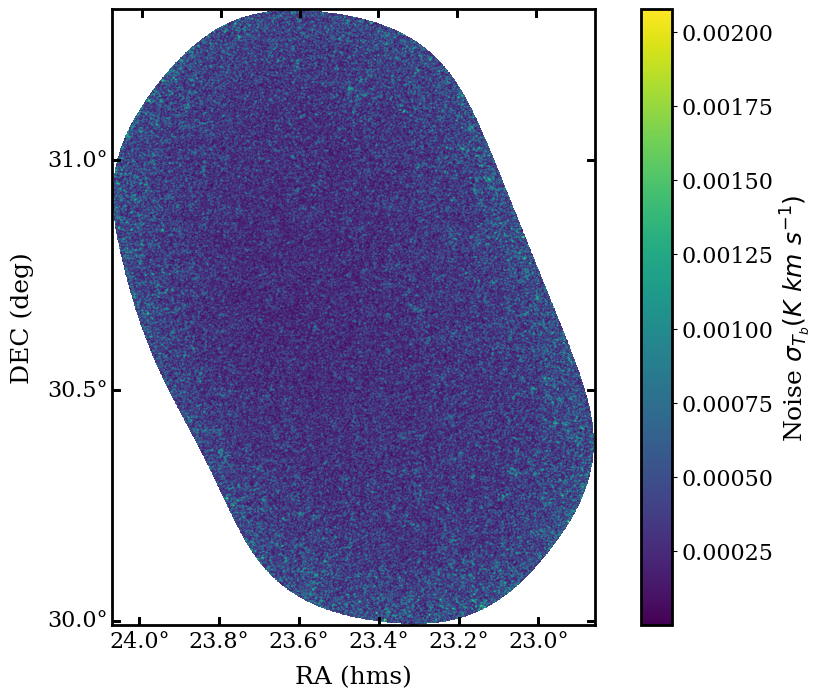

In [5]:
## Generate Noise Map by Combining Two Sets of Channels with No Emission

# noise_channels_1  = d[0].data[0:5]
noise_channels_2  = d[0].data[-3:]
all_noise_channels = noise_channels_2.copy() #np.vstack([noise_channels_1, noise_channels_2])
noise_map = np.std(all_noise_channels, axis = 0)

print('Shape of Noise Map:', noise_map.shape)

plt.figure(figsize = (12,8))
ax = plt.subplot(111, projection=cube.wcs.celestial)

ax.tick_params(labelsize = 16)
# ax.tick_params(labelsize = 14)
plt.imshow(noise_map)
cb = plt.colorbar()
cb.set_label('Noise $\sigma_{T_b} (K \ km \ s^{-1})$', fontsize = 18)
ax.set_xlabel('RA (hms)', fontsize = 18)
ax.set_ylabel('DEC (deg)', fontsize = 18)


for l in cb.ax.yaxis.get_ticklabels():
    l.set_fontsize(16)
for axc in ax.coords: axc.set_format_unit('deg', decimal = True) 
fix_ticks(ax)

plt.savefig('KochNoiseMap.pdf', bbox_inches = 'tight')

# MOMENT 0 MAP

In [6]:
geometry = EllipseGeometry(x0 = 650, y0= 790, sma=790, eps=0.45,
                           pa= 109 * np.pi / 180.0)

ellipse = Ellipse(moment_0.data, geometry)

aper = EllipticalAperture((geometry.x0, geometry.y0), geometry.sma,
                          geometry.sma * (1 - geometry.eps),
                          geometry.pa)

In [7]:
##      major, then minor                  
edges_pix = [(370,1525),(980,80),(245,620),(1050,970)]
edges_sc = []

for (a,b) in edges_pix: 
    sc=  cube.wcs[0].pixel_to_world(a,b)
    edges_sc.append(sc)

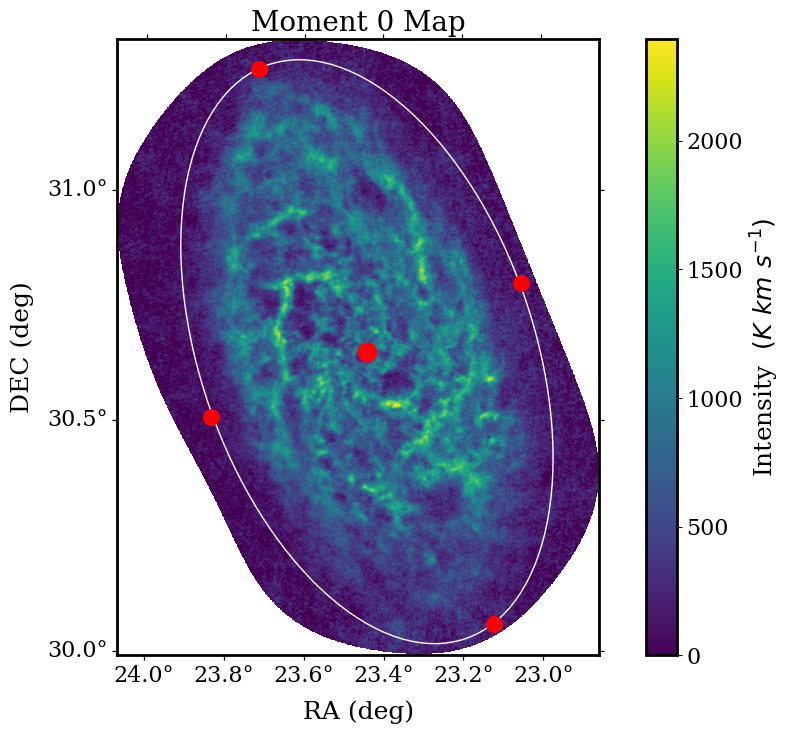

In [8]:
plt.figure(figsize = (12,8))
ax = plt.subplot(111, projection=cube.wcs.celestial)
ax.set_xlabel('RA (deg)', fontsize = 18)
ax.set_ylabel('DEC (deg)', fontsize = 18)

plt.imshow(moment_0.hdu.data, vmin = 0)
cb = plt.colorbar()
cb.set_label(r'Intensity $\ (K \ km \ s^{-1})$', fontsize = 18)



for l in cb.ax.yaxis.get_ticklabels():
    l.set_fontsize(16)
for axc in ax.coords: axc.set_format_unit('deg', decimal = True) 
ax.tick_params(labelsize = 16)



aper.plot(color='white')

centroid = cube.wcs[0].pixel_to_world(geometry.x0, geometry.y0)

ax.scatter(centroid.ra.deg, centroid.dec.deg, transform=ax.get_transform('world'),
           s=700, marker = '.', color='red')



for sc in edges_sc:
    ax.scatter(sc.ra.deg, sc.dec.deg, transform=ax.get_transform('world'),
           s=500, marker = '.', color='red', zorder = 5)

plt.title('Moment 0 Map',fontsize = 20)

plt.savefig('KochMoment0.pdf', bbox_inches = 'tight')
    

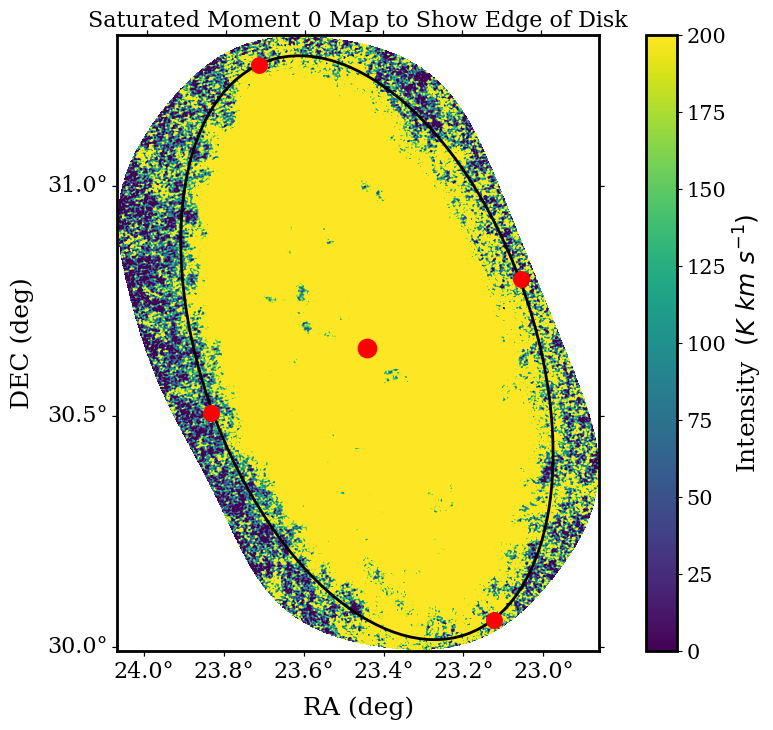

In [9]:
plt.figure(figsize = (12,8))
ax = plt.subplot(111, projection=cube.wcs.celestial)
ax.set_xlabel('RA (deg)', fontsize = 18)
ax.set_ylabel('DEC (deg)', fontsize = 18)


for axc in ax.coords: axc.set_format_unit('deg', decimal = True) 
ax.tick_params(labelsize = 16)

plt.imshow(moment_0.data, vmin = 0, vmax = 200)
cb = plt.colorbar()
cb.set_label(r'Intensity $\ (K \ km \ s^{-1})$', fontsize = 18)
for l in cb.ax.yaxis.get_ticklabels():
    l.set_fontsize(15)

aper.plot(color='black', lw = 2)

centroid = cube.wcs[0].pixel_to_world(geometry.x0, geometry.y0)

ax.scatter(centroid.ra.deg, centroid.dec.deg, transform=ax.get_transform('world'),
           s=700, marker = '.', color='red')



for sc in edges_sc:
    ax.scatter(sc.ra.deg, sc.dec.deg, transform=ax.get_transform('world'),
           s=500, marker = '.', color='red', zorder = 5)

plt.title('Saturated Moment 0 Map to Show Edge of Disk', fontsize = 16)
plt.savefig('KochSaturatedMoment0.pdf',bbox_inches = 'tight')    

# MOMENT 1 MAP

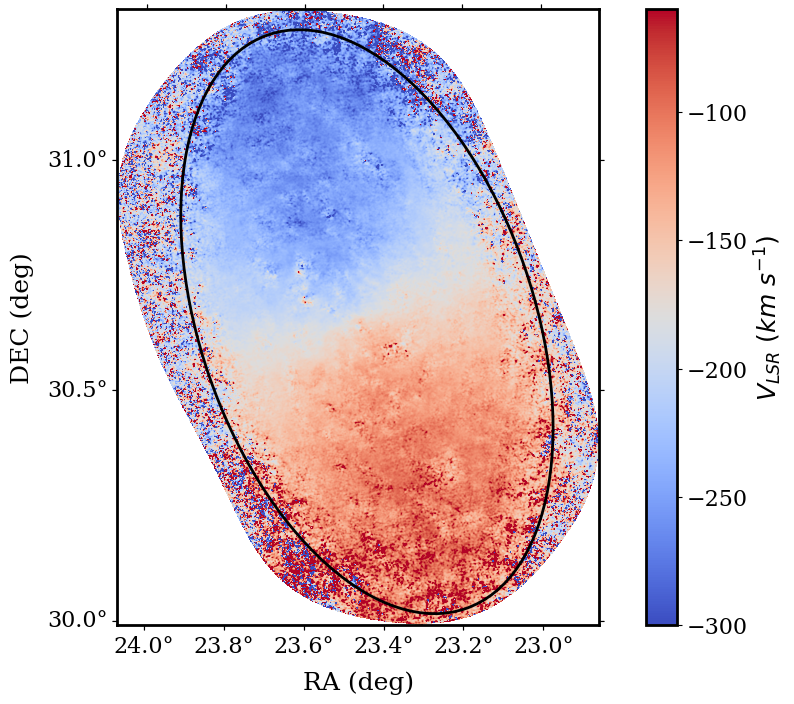

In [10]:
plt.figure(figsize = (12,8))
ax = plt.subplot(111, projection=cube.wcs.celestial)

ax.tick_params(labelsize = 16)
plt.imshow(moment_1.hdu.data, vmin = -300, vmax = -60, cmap = 'coolwarm')
cb = plt.colorbar()
cb.set_label(r'$V_{LSR} \ (km \ s^{-1})$', fontsize = 18)
ax.set_xlabel('RA (deg)', fontsize = 18)
ax.set_ylabel('DEC (deg)', fontsize = 18)

for l in cb.ax.yaxis.get_ticklabels():
    l.set_fontsize(16)
for axc in ax.coords: axc.set_format_unit('deg', decimal = True) 

aper.plot(color='black', lw = 2)

plt.savefig('KochMoment1.pdf', bbox_inches = 'tight')

In [11]:
len(np.isfinite(cube))

94

# MOMENT 2 MAP

In [73]:
moment_2  = np.sqrt(np.abs(np.asarray(cube.moment(order=2))))
moment_2_masked  = moment_2.copy()
moment_2_masked[moment_2_masked >  75] = np.nan

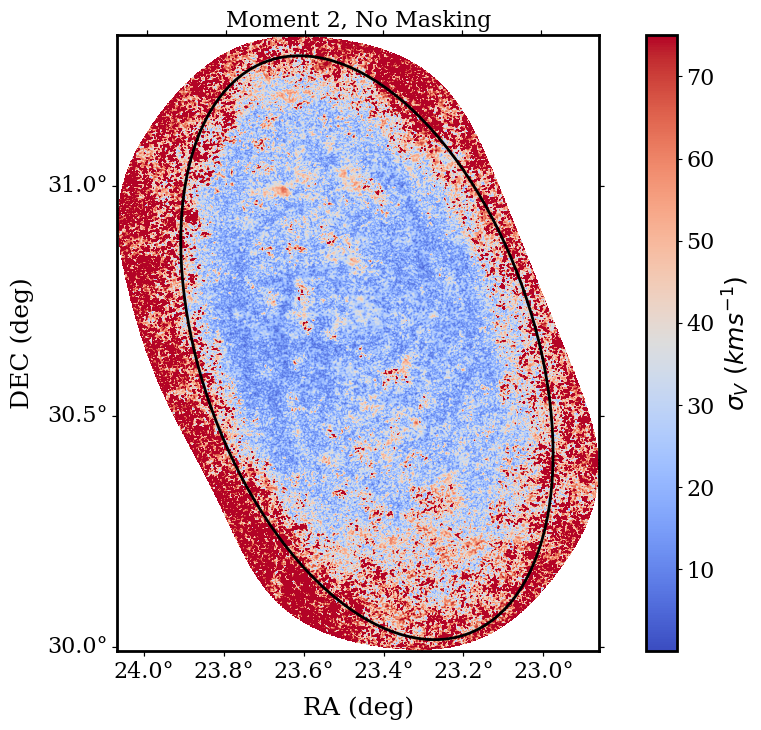

In [85]:
plt.figure(figsize = (12,8))
ax = plt.subplot(111, projection=cube.wcs.celestial)

ax.tick_params(labelsize = 16)
plt.imshow(moment_2, vmax = 75, cmap = 'coolwarm')
cb = plt.colorbar()
cb.set_label(r'$\sigma_V \ (km s^{-1})$', fontsize = 18)
ax.set_xlabel('RA (deg)', fontsize = 18)
ax.set_ylabel('DEC (deg)', fontsize = 18)


for l in cb.ax.yaxis.get_ticklabels():
    l.set_fontsize(16)
for axc in ax.coords: axc.set_format_unit('deg', decimal = True) 
plt.title(r'Moment 2, No Masking', fontsize = 16)    
    
aper.plot(color='black', lw =2)

plt.savefig('KochMoment2.pdf', bbox_inches = 'tight')

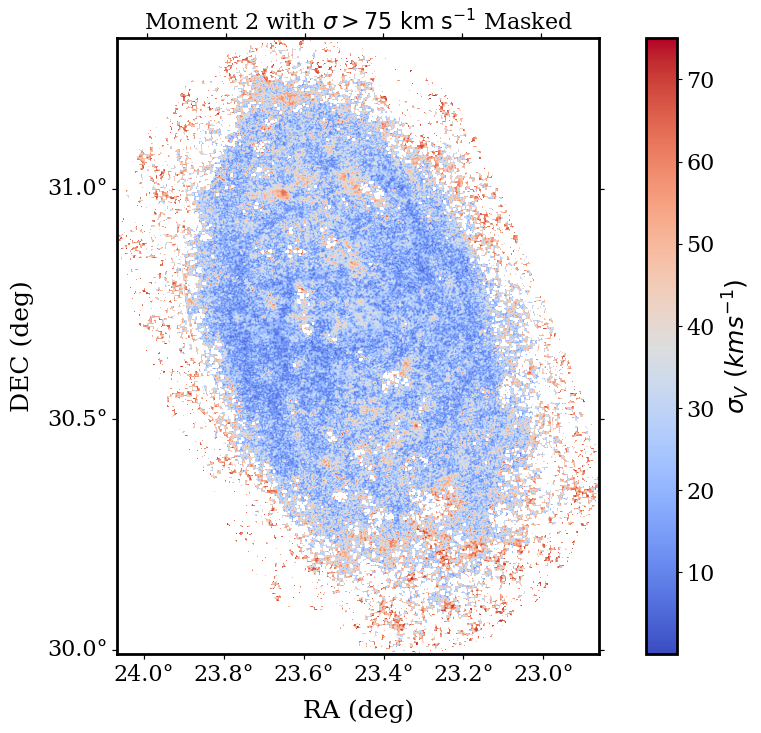

In [84]:
plt.figure(figsize = (12,8))
ax = plt.subplot(111, projection=cube.wcs.celestial)

from matplotlib.colors import LogNorm



ax.tick_params(labelsize = 16)
plt.imshow(moment_2_masked, cmap = 'coolwarm', vmax  = 75)
cb = plt.colorbar()
cb.set_label(r'$\sigma_V \ (km s^{-1})$', fontsize = 18)
ax.set_xlabel('RA (deg)', fontsize = 18)
ax.set_ylabel('DEC (deg)', fontsize = 18)


for l in cb.ax.yaxis.get_ticklabels():
    l.set_fontsize(16)
for axc in ax.coords: axc.set_format_unit('deg', decimal = True) 

plt.title(r'Moment 2 with $\sigma > 75 \rm \ km \ s^{-1}$ Masked', fontsize = 16)    

aper.plot(color='white')

plt.savefig('KochMoment2_MASKED.pdf', bbox_inches = 'tight')

# CALCULATION OF GALAXY HI MASS

## Calculation of Major and Minor Axes, Area Version 1

In [ ]:
sc_maj_top = edges_sc[0]
sc_maj_bottom = edges_sc[1]

sc_minor_left  = edges_sc[2]
sc_minor_right = edges_sc[3]

In [ ]:
angsep_amaj_deg = sc_maj_top .separation(sc_maj_bottom).deg
angsep_bmin_deg = sc_minor_left.separation(sc_minor_right).deg

a_major_kpc = round((np.arctan(np.radians(angsep_amaj_deg)) * 840)/2,1) * u.kpc
b_minor_kpc = round((np.arctan(np.radians(angsep_bmin_deg)) * 840)/2,1) * u.kpc

print('Major, Minor Axis Lengths in kpc: ', a_major_kpc, b_minor_kpc)

In [ ]:
area1_kpc2 = np.pi * a_major_kpc * b_minor_kpc
# print("Area:", area1_kpc2)

area1_cm2 =  (area1_kpc2).to(u.cm**2)
print("Area:", area1_cm2)

In [ ]:
phot_table = aperture_photometry(moment_0.hdu.data, aper)
mom0_summed = phot_table['aperture_sum'].value / (np.pi * geometry.sma * geometry.sma * (1-geometry.eps))
NH_cm2 = ((1.82e18) * mom0_summed)

hydrogen_mass_Msun = 8.419e-58 * u.Msun


print('Column Density:', NH_cm2 * (u.cm**-2))

In [ ]:
(NH_cm2  * (u.cm**-2)) * area1_cm2 * hydrogen_mass_Msun

# PV CURVE

In [ ]:
from pvextractor import extract_pv_slice, Path

In [ ]:
path = Path([edges_pix[0], edges_pix[1]])

In [ ]:
pvdiagram = extract_pv_slice(cube=cube, path=path, spacing=2.5)

In [ ]:

plt.figure(figsize = (12,8))
ax = plt.subplot(111, projection=cube.wcs.celestial)
ax.set_xlabel('RA (deg)', fontsize = 18)
ax.set_ylabel('DEC (deg)', fontsize = 18)

for l in cb.ax.yaxis.get_ticklabels():
    l.set_fontsize(16)
for axc in ax.coords: axc.set_format_unit('deg', decimal = True) 
ax.tick_params(labelsize = 16)

ax.imshow(moment_0.data)
aper.plot(color='white')


path.show_on_axis(ax, spacing=1, color='r')
plt.savefig('KochExtractedPath.pdf', bbox_inches = 'tight')

In [ ]:
plt.figure(figsize=(8,8))
ax = plt.gca()

ax.set_ylabel("Velocity [km/s]", fontsize = 19)
ax.set_xlabel("Offset [arcmin]", fontsize = 19)
ax.set_aspect(.25)
fix_ticks(ax)
ax.tick_params(labelsize = 16, direction = 'in')
# ax.coords[1].set_format_unit(u.km/u.s)
plt.imshow(pvdiagram.data, aspect = .005, extent = [0,1.6,-60,-300])
ax.invert_yaxis()

vmax = -100
vmin = -280
vsys = (vmax + vmin)/2
print(vmax, vmin, vsys)
ax.axhline(vmax, color = 'red')
ax.axhline(vmin , color = 'red')
ax.axhline(vsys, color = 'white', ls = '--')
plt.savefig('KochPV.pdf', bbox_inches = 'tight')

# -----------------------------------------------------------------------------------------------

# FULL GALAXY SPECTRUM

In [80]:
integrated_tb = []

for i in range(cube.shape[0]):
    frame = cube[i]

    geometry = EllipseGeometry(x0 = 650, y0= 790, sma=790, eps=0.45,
                           pa= 109 * np.pi / 180.0)
    ellipse = Ellipse(moment_0.data, geometry)

    aper = EllipticalAperture((geometry.x0, geometry.y0), geometry.sma,
                          geometry.sma * (1 - geometry.eps),
                          geometry.pa)
    
    phot_table = aperture_photometry(frame, aper)
    integrated_tb.append(phot_table['aperture_sum'].value)

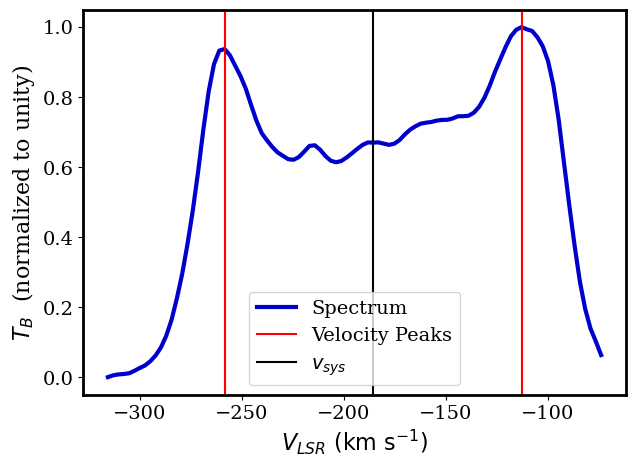

In [83]:
plt.figure(figsize = (7,5))
plt.plot(cube.spectral_axis, np.asarray(integrated_tb)/np.asarray(integrated_tb).max(), color = 'mediumblue', lw = 3, label = 'Spectrum')
plt.ylabel(r'$T_B$  (normalized to unity)', fontsize = 16)
plt.xlabel(r'$V_{LSR} \ (\rm km \ s^{-1})}$', fontsize = 16)
plt.gca().tick_params(labelsize = 14)

vmax = cube.spectral_axis[0:20].value[np.argmax(integrated_tb[0:20])]
vmin = cube.spectral_axis[20:].value[np.argmax(integrated_tb[20:])]
vsys = (vmin + vmax)/2

plt.axvline(vmin, color = 'red', label = 'Velocity Peaks')
plt.axvline(vmax, color = 'red')
plt.axvline(vsys, color = 'black', label = r'$v_{sys}$')
plt.legend(loc = 'lower center', fontsize = 14)
#saveT = True
plt.savefig('KochSpectrum.pdf', bbox_inches = 'tight')

In [ ]:
len(cube.spectral_axis)

In [ ]:
print([round(v,0) for v in [vmin,vmax,vsys, vmin-vsys]])

In [ ]:
from astropy import constants as const
Rmax = (9.6 + 5.4)/2 * u.kpc
Vflat = 90 * u.km/u.s
Vmax = 73 * u.km/u.s
M1 = ((Vflat)**2 * (Rmax) / const.G).to(u.Msun)
M2 = ((Vmax)**2 * (Rmax) / const.G).to(u.Msun)

In [ ]:
M1

In [ ]:
M2

In [ ]:
Rmax